In [1]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



In [2]:
library(ggplot2)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [3]:
library("clustree")

Loading required package: ggraph



In [4]:

## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [5]:
normal.data <- Read10X(data.dir = "./filtered_feature_MGUSPC_1")
normal <- CreateSeuratObject(counts = normal.data, project = "MGUSPC1", min.cells = 3, min.features = 100)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [6]:
normal

An object of class Seurat 
15795 features across 4258 samples within 1 assay 
Active assay: RNA (15795 features, 0 variable features)

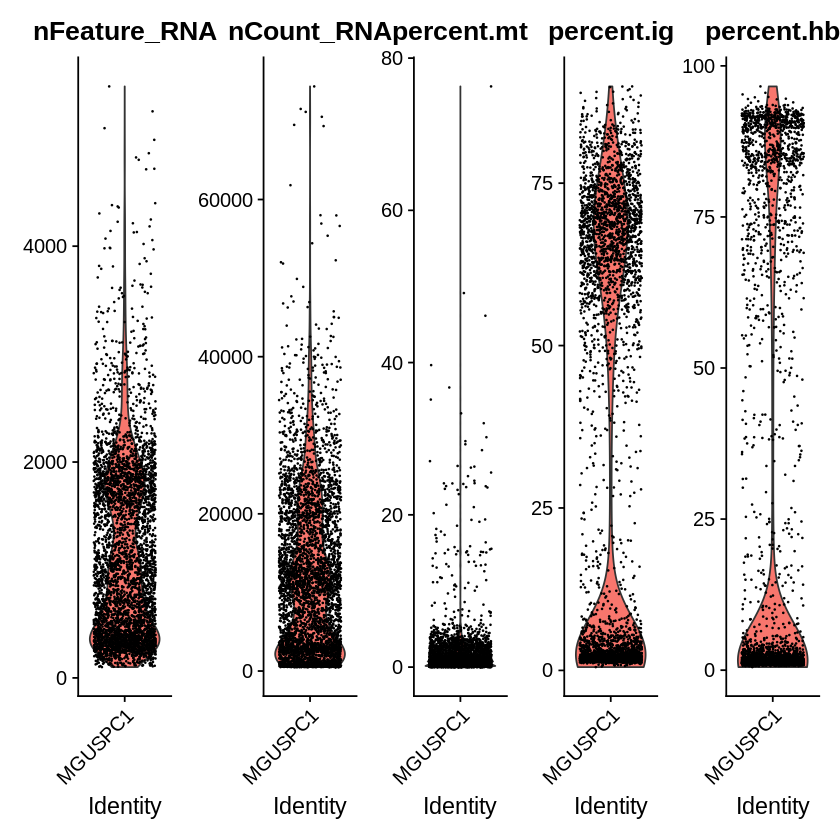

In [7]:
normal[["percent.mt"]] <- PercentageFeatureSet(normal, pattern = "^MT-")
normal[["percent.ig"]] <- PercentageFeatureSet(normal, pattern = "^IG")
normal[["percent.hb"]] <- PercentageFeatureSet(normal, pattern = "^HB")
VlnPlot(normal, features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.ig","percent.hb"), ncol = 5)

In [8]:
summary(normal@meta.data)

   orig.ident     nCount_RNA     nFeature_RNA    percent.mt     
 MGUSPC1:4258   Min.   :  500   Min.   : 100   Min.   : 0.0000  
                1st Qu.: 3011   1st Qu.: 419   1st Qu.: 0.2994  
                Median :10388   Median : 977   Median : 0.7868  
                Mean   :11818   Mean   :1148   Mean   : 1.5125  
                3rd Qu.:18351   3rd Qu.:1759   3rd Qu.: 1.5032  
                Max.   :74392   Max.   :5480   Max.   :76.2783  
   percent.ig        percent.hb     
 Min.   : 0.5093   Min.   : 0.5066  
 1st Qu.: 1.9232   1st Qu.: 1.2077  
 Median : 7.2230   Median : 1.5931  
 Mean   :32.6343   Mean   :23.0265  
 3rd Qu.:67.0799   3rd Qu.:52.0486  
 Max.   :89.8936   Max.   :96.5988  

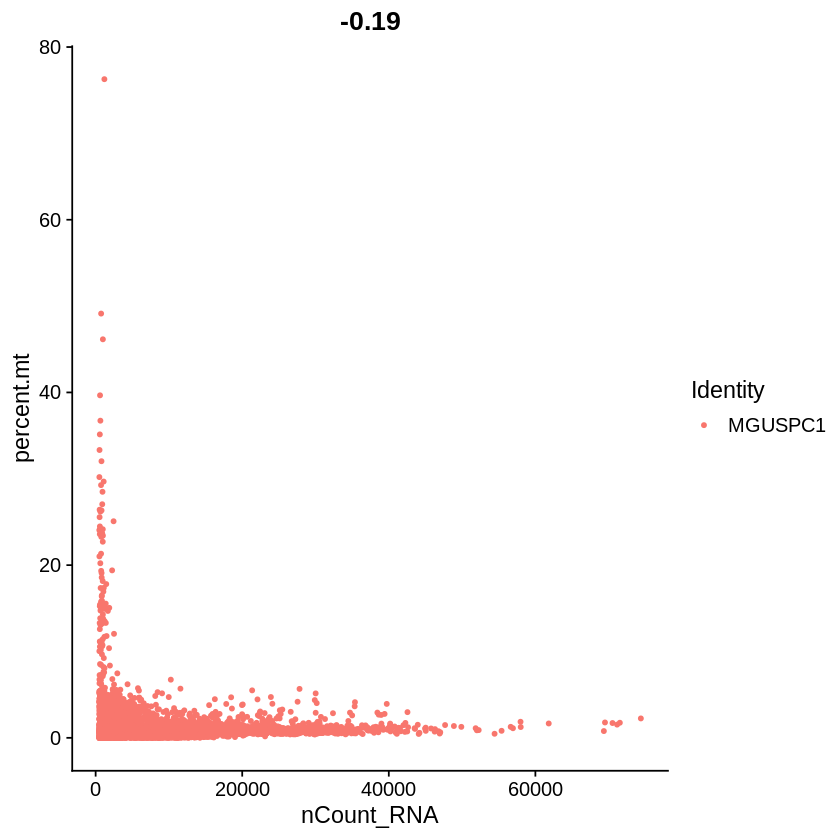

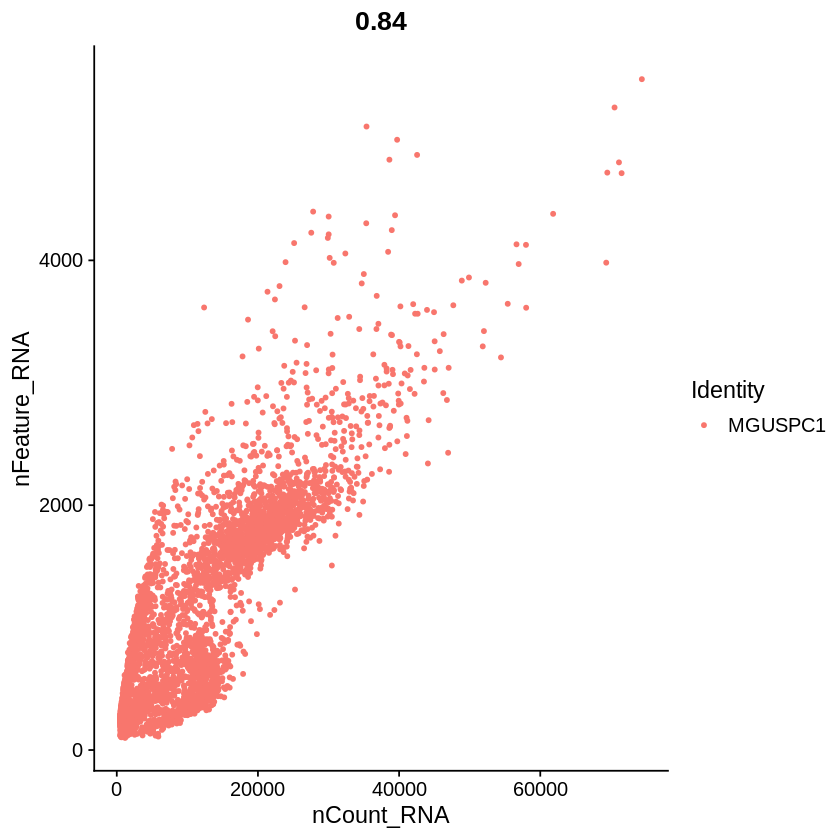

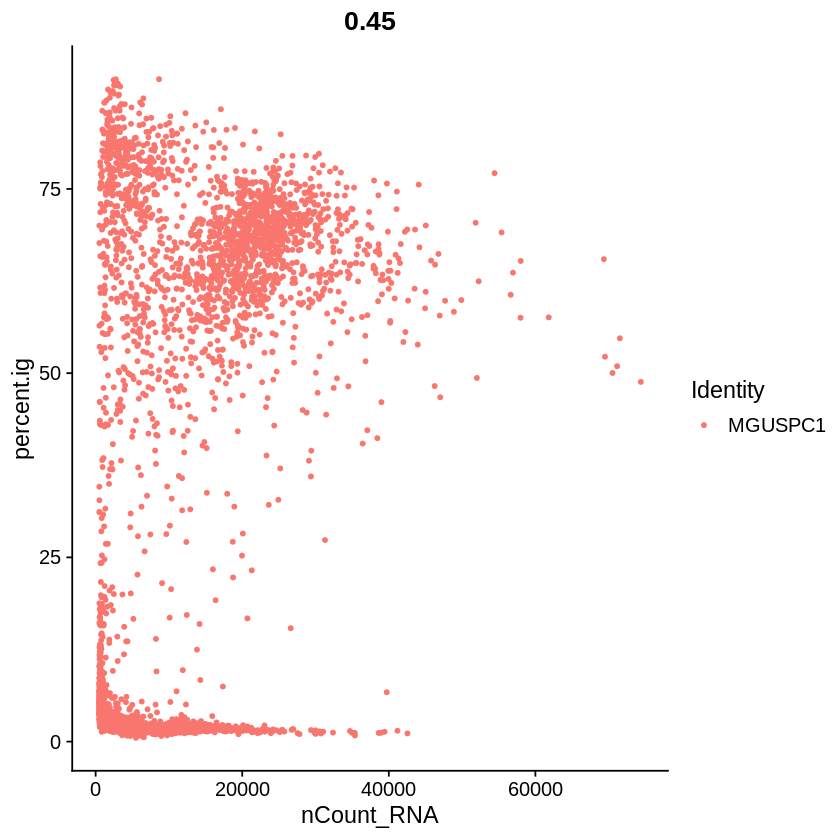

In [9]:
plot1 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot3 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.ig")
plot1
plot2
plot3

In [10]:
normal <- subset(normal, subset = nFeature_RNA > 200 & nFeature_RNA < 4000 & percent.mt < 5 & percent.hb<2)
normal

An object of class Seurat 
15795 features across 2442 samples within 1 assay 
Active assay: RNA (15795 features, 0 variable features)

In [11]:
normal <- NormalizeData(normal, normalization.method = "LogNormalize", scale.factor = 10000)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 131 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 131 rows containing missing values (geom_point).”


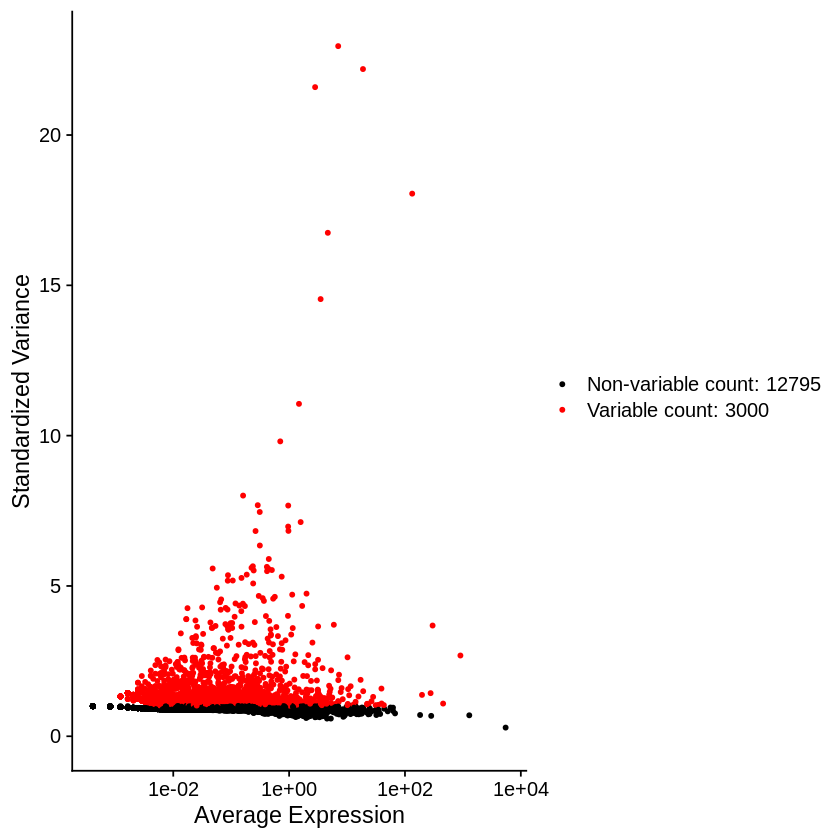

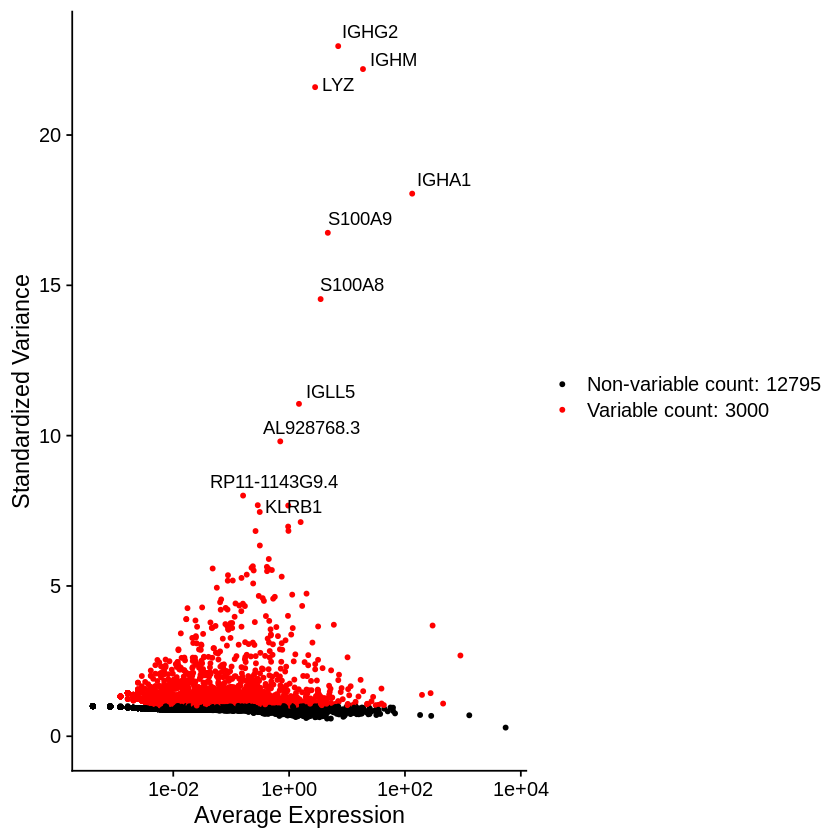

In [12]:
normal <- FindVariableFeatures(normal, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

In [13]:
all.genes <- rownames(normal)
normal <- ScaleData(normal, features = all.genes)

Centering and scaling data matrix



In [14]:
length(VariableFeatures(object = normal))

[1] 3000

In [15]:
normal <- RunPCA(normal, features = VariableFeatures(object = normal))

PC_ 1 
Positive:  MZB1, IGLC3, DERL3, SSR4, IGHG1, IGHG4, FKBP11, DNAJB9, IGKC, JCHAIN 
	   HERPUD1, SEC11C, FKBP2, SELM, PRDX4, CCND1, ITM2C, MANF, XBP1, MDK 
	   ERLEC1, FRZB, PDIA6, JUN, SDF2L1, PLPP5, HSP90B1, UBE2J1, NUCB2, SPCS3 
Negative:  CD52, ACTB, PFN1, TMSB4X, SH3BGRL3, S100A4, HCST, CORO1A, PTPRC, GAPDH 
	   RPS24, IFITM2, IL32, S100A10, CCL5, NKG7, ACTG1, ANXA1, RPS2, LCP1 
	   LAPTM5, ITGB2, HLA-DPB1, S100A6, CD3D, CST7, ARPC1B, HLA-DRB1, CD3E, GZMA 
PC_ 2 
Positive:  FCN1, LYZ, CSTA, LST1, MNDA, FCER1G, VCAN, CST3, CD14, TYROBP 
	   S100A9, CFP, CLEC12A, SERPINA1, MPEG1, S100A8, TYMP, TNFSF13B, CFD, KCTD12 
	   CD36, FGL2, S100A12, CTSS, AIF1, LGALS2, DUSP6, MS4A6A, CLEC7A, LINC01272 
Negative:  IL32, CCL5, NKG7, CST7, CD3D, GZMA, GZMH, CD3E, GNLY, TRAC 
	   CD2, TRBC2, PRF1, CD3G, CCL4, FGFBP2, GZMM, LCK, KLRD1, GZMB 
	   CLEC2D, TRGC2, C12orf75, CD8A, EVL, HOPX, TRBC1, IFITM1, KLRG1, PYHIN1 
PC_ 3 
Positive:  APOC1, SEPP1, HMOX1, C1QA, APOE, C1QB, C1QC, FABP5, FABP3, 

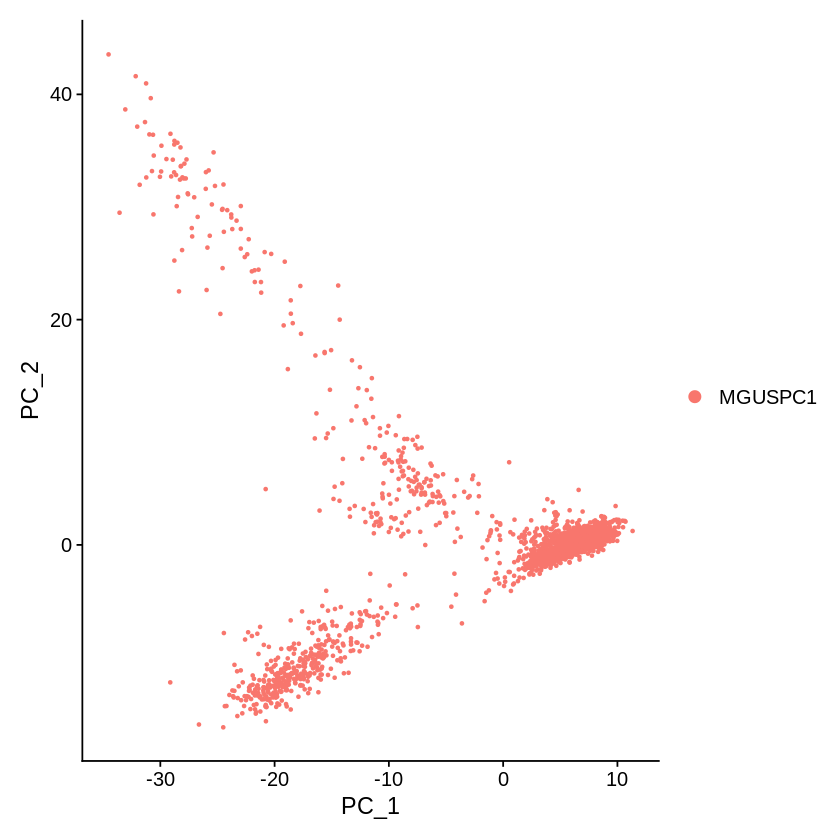

In [16]:
DimPlot(normal, reduction = "pca")

In [17]:
normal <- JackStraw(normal, num.replicate = 100)
normal <- ScoreJackStraw(normal, dims = 1:20)

Warning message:
“Removed 42787 rows containing missing values (geom_point).”


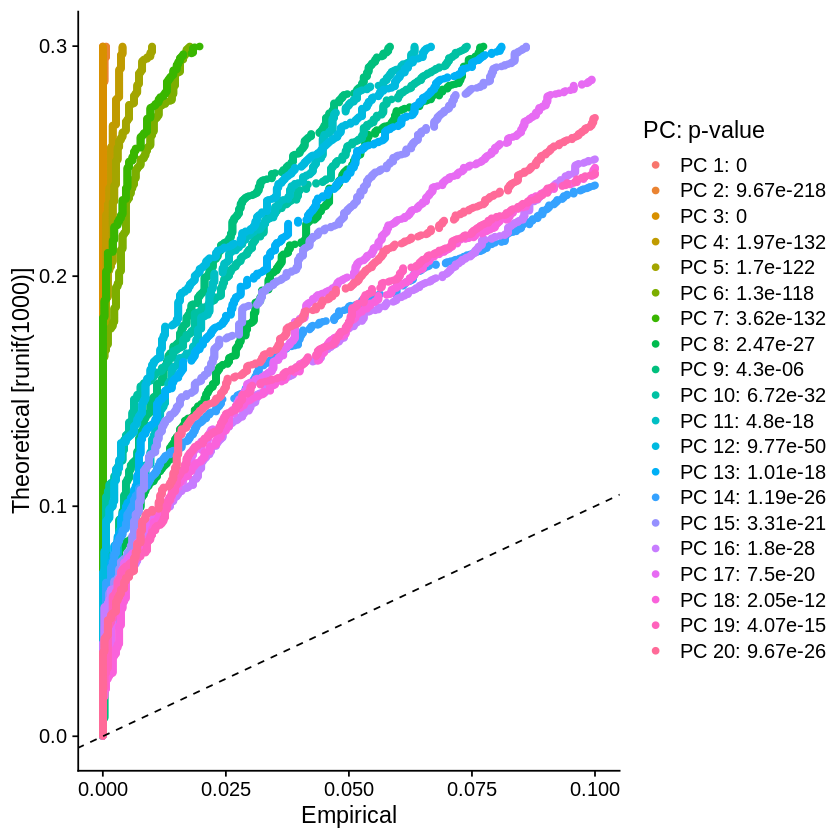

In [18]:
JackStrawPlot(normal, dims = 1:20)

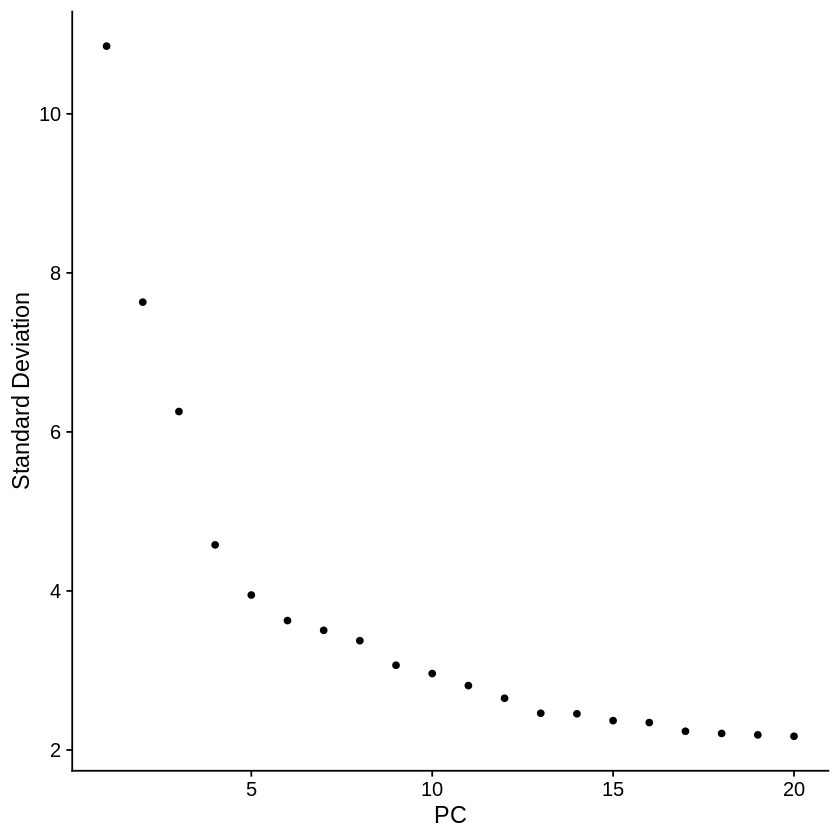

In [19]:
ElbowPlot(normal)

In [20]:
normal <- RunUMAP(normal, dims = 1:8)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
13:53:31 UMAP embedding parameters a = 0.9922 b = 1.112

13:53:31 Read 2442 rows and found 8 numeric columns

13:53:31 Using Annoy for neighbor search, n_neighbors = 30

13:53:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:53:31 Writing NN index file to temp file /tmp/RtmpNRTwom/file82b7f69abd963

13:53:31 Searching Annoy index using 1 thread, search_k = 3000

13:53:31 Annoy recall = 100%

13:53:32 Commencing smooth kNN distance calibration using 1 thread

13:53:32 Initializing fro

In [21]:
options(repr.plot.height=8,repr.plot.width=8)

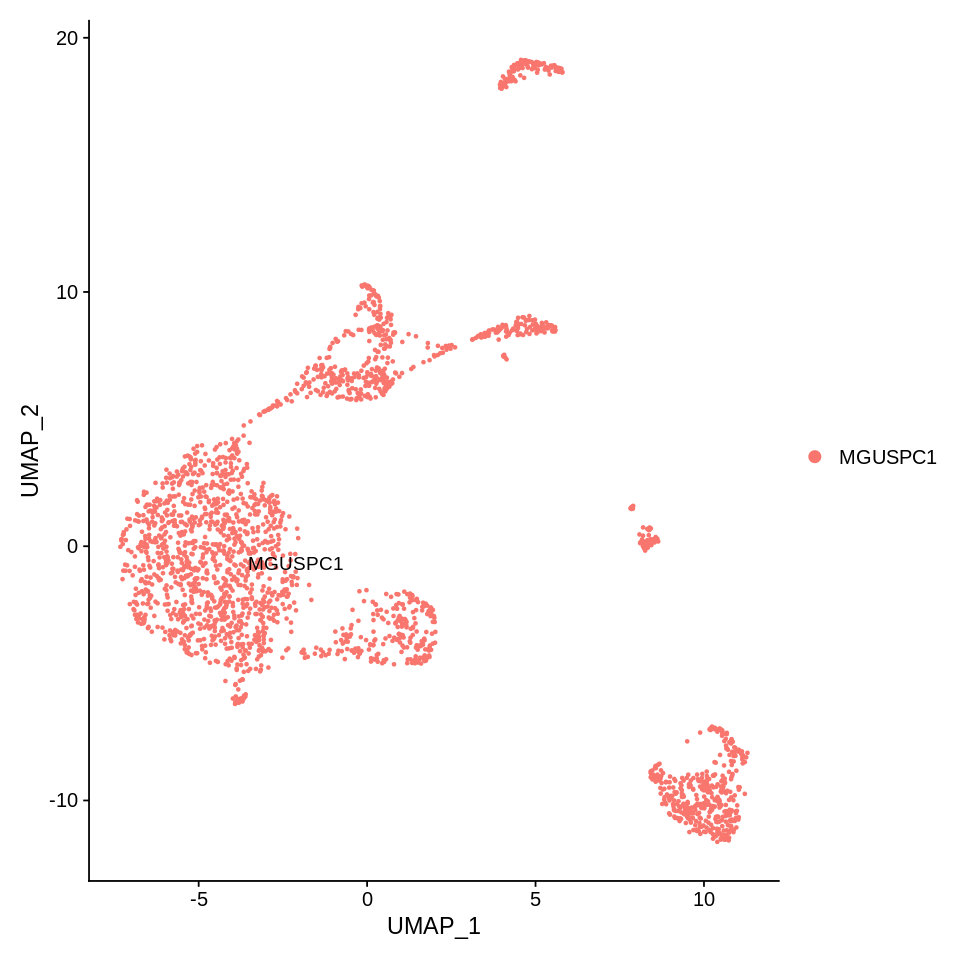

In [22]:
DimPlot(normal, reduction = "umap",label=T)

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Loading required package: modes



NULL


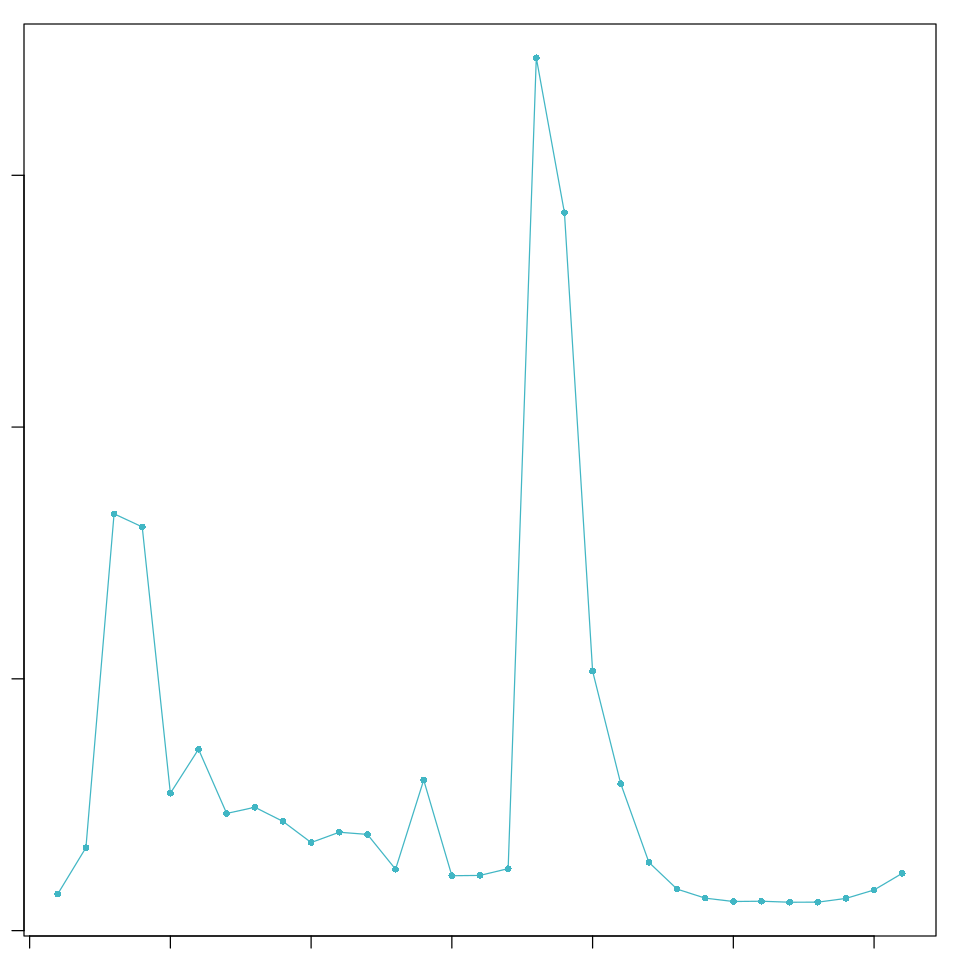

In [23]:
library(DoubletFinder)
sweep.res.list <- paramSweep_v3(normal, PCs = 1:8, sct = FALSE)
for(i in 1:length(sweep.res.list)){
  if(length(sweep.res.list[[i]]$pANN[is.nan(sweep.res.list[[i]]$pANN)]) != 0){
    if(i != 1){
      sweep.res.list[[i]] <- sweep.res.list[[i - 1]]
    }else{
      sweep.res.list[[i]] <- sweep.res.list[[i + 1]]
    }
  }
}
sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn <- find.pK(sweep.stats)
pk_v <- as.numeric(as.character(bcmvn$pK))
pk_good <- pk_v[bcmvn$BCmetric==max(bcmvn$BCmetric)]
nExp_poi <- round(0.1*length(colnames(normal)))

In [24]:
normal <- doubletFinder_v3(normal, PCs = 1:8, pN = 0.25, pK = pk_good, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)

[1] "Creating 814 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [25]:
colnames(normal@meta.data)[ncol(normal@meta.data)]="DoubletFinder"

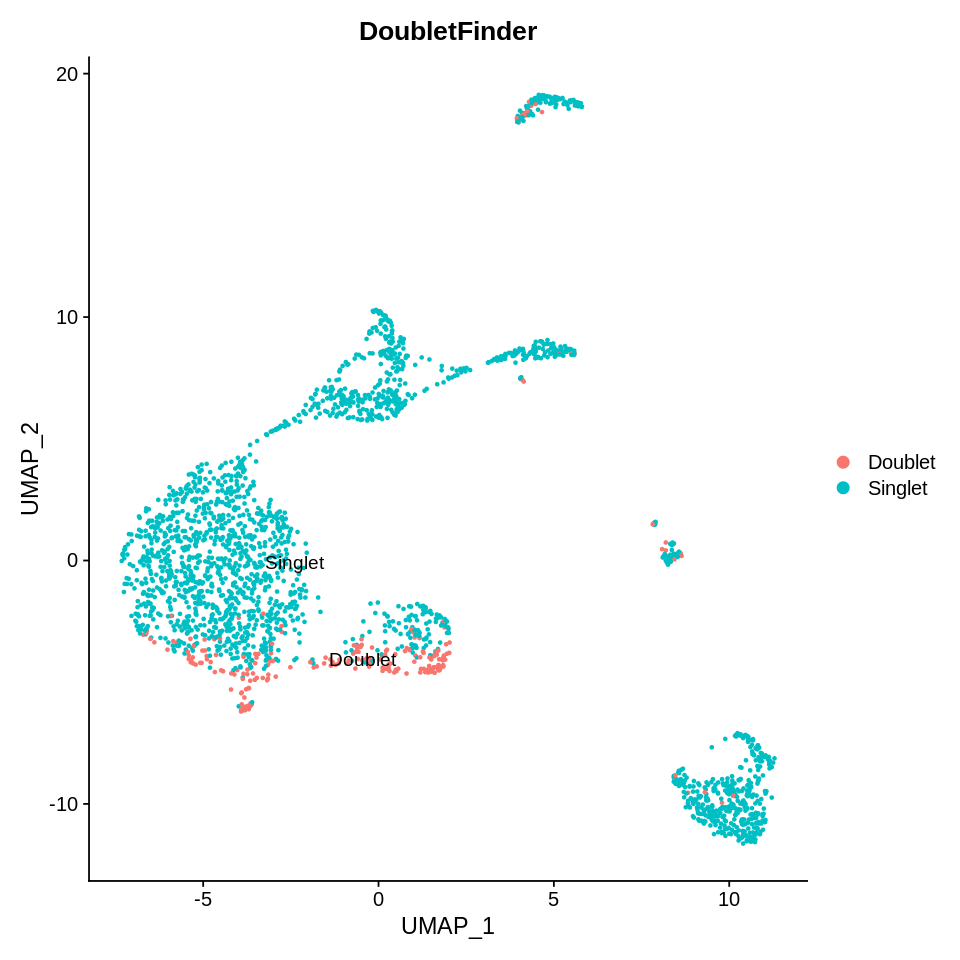

In [26]:
DimPlot(normal, reduction = "umap",label=T,group.by='DoubletFinder')

In [27]:
normal2<-subset(normal,DoubletFinder=='Singlet')

In [28]:
normal
normal2

An object of class Seurat 
15795 features across 2442 samples within 1 assay 
Active assay: RNA (15795 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
15795 features across 2198 samples within 1 assay 
Active assay: RNA (15795 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 215 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 215 rows containing missing values (geom_point).”


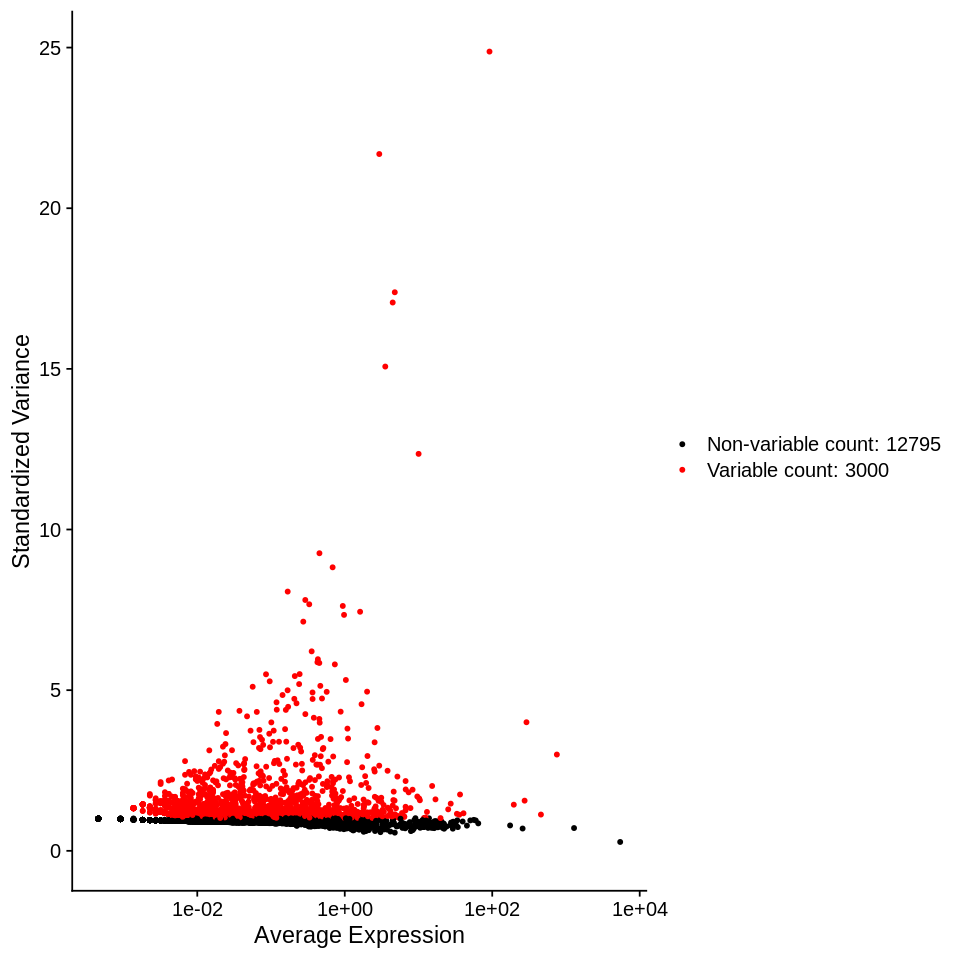

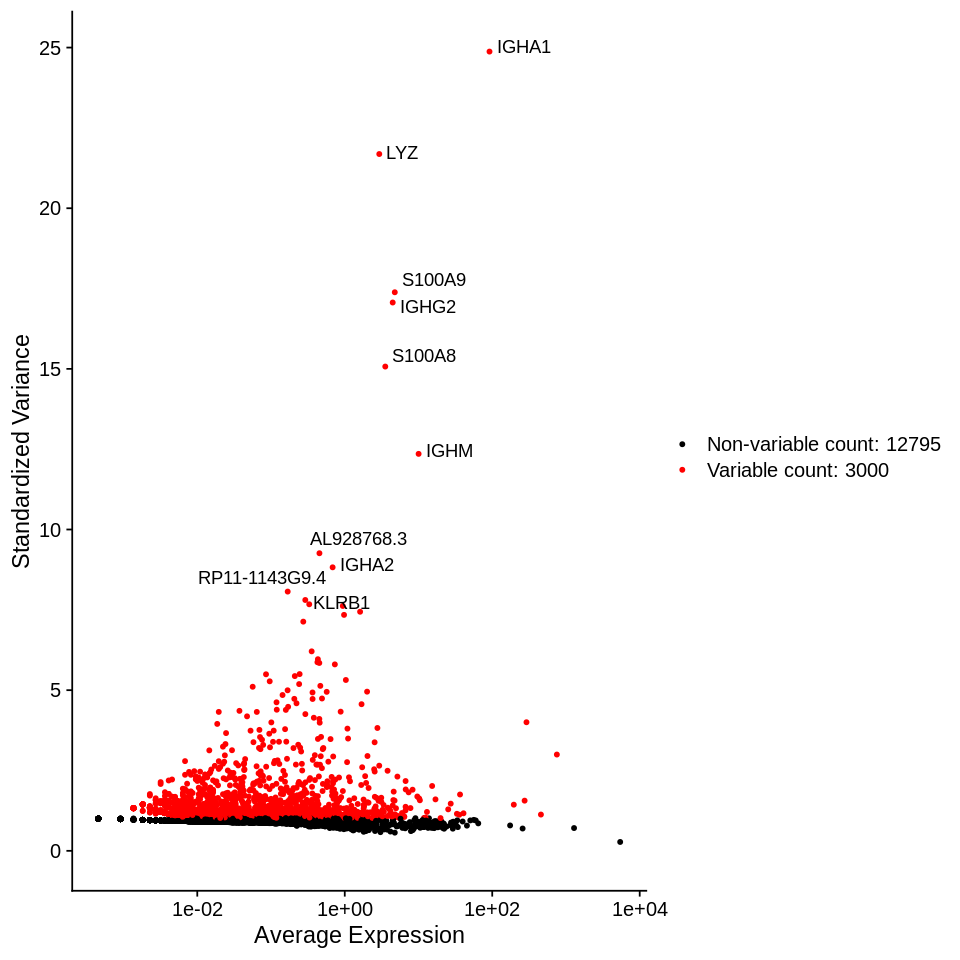

In [29]:
normal2 <- FindVariableFeatures(normal2, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal2), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal2)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

In [30]:
all.genes <- rownames(normal2)
normal2 <- ScaleData(normal2, features = all.genes)

Centering and scaling data matrix



In [31]:
length(VariableFeatures(object = normal2))

[1] 3000

In [32]:
normal2 <- RunPCA(normal2, features = VariableFeatures(object = normal2))

PC_ 1 
Positive:  MZB1, IGLC3, IGHG1, DERL3, IGHG4, SSR4, JCHAIN, IGKC, FKBP11, DNAJB9 
	   HERPUD1, SEC11C, SELM, FKBP2, CCND1, PRDX4, ITM2C, MDK, FRZB, XBP1 
	   MANF, ERLEC1, SPCS2, PDIA6, JUN, PLPP5, SDF2L1, HSP90B1, UBE2J1, NUCB2 
Negative:  CD52, ACTB, PFN1, SH3BGRL3, TMSB4X, S100A4, HCST, PTPRC, CORO1A, GAPDH 
	   ARHGDIB, IL32, IFITM2, CCL5, NKG7, ACTG1, S100A10, ANXA1, LAPTM5, ITGB2 
	   CD3D, LCP1, CST7, S100A6, HLA-DPB1, CD48, CD3E, GZMA, GZMH, ARPC1B 
PC_ 2 
Positive:  FCN1, LYZ, CSTA, VCAN, MNDA, LST1, FCER1G, CD14, CST3, CFP 
	   CLEC12A, S100A9, TYROBP, MPEG1, SERPINA1, KCTD12, FGL2, TYMP, S100A8, CFD 
	   TNFSF13B, CD36, S100A12, DUSP6, CLEC7A, CTSS, LGALS2, GRN, RP11-1143G9.4, CYBB 
Negative:  IL32, CCL5, NKG7, CST7, CD3D, GZMA, GZMH, CD3E, GNLY, TRAC 
	   CD2, TRBC2, PRF1, CD3G, CCL4, FGFBP2, LCK, GZMM, KLRD1, CLEC2D 
	   GZMB, C12orf75, TRGC2, CD8A, EVL, HOPX, IFITM1, TRBC1, KLRG1, PYHIN1 
PC_ 3 
Positive:  MT-ND2, HLA-C, HLA-B, HLA-A, DUSP1, NEAT1, TSC22D3, S100A6, 

In [33]:
normal2 <- JackStraw(normal2, num.replicate = 100)
normal2 <- ScoreJackStraw(normal2, dims = 1:20)

Warning message:
“Removed 43441 rows containing missing values (geom_point).”


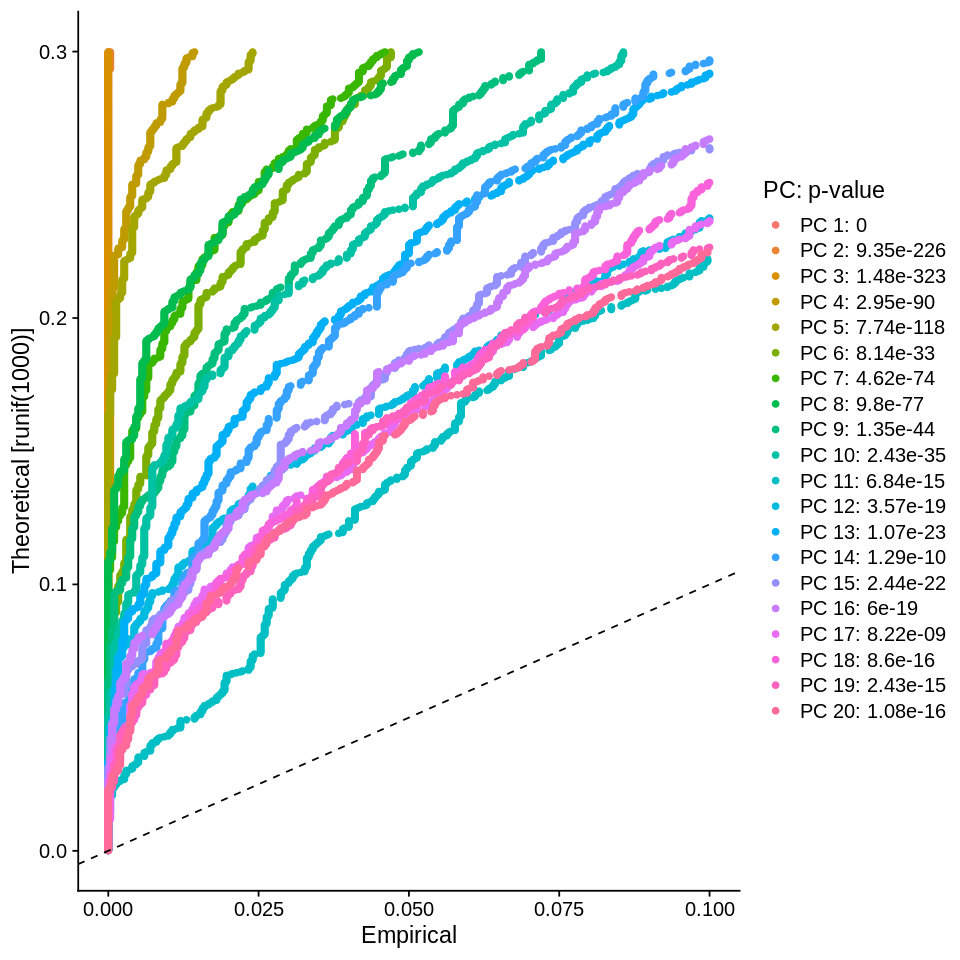

In [34]:
JackStrawPlot(normal2, dims = 1:20)

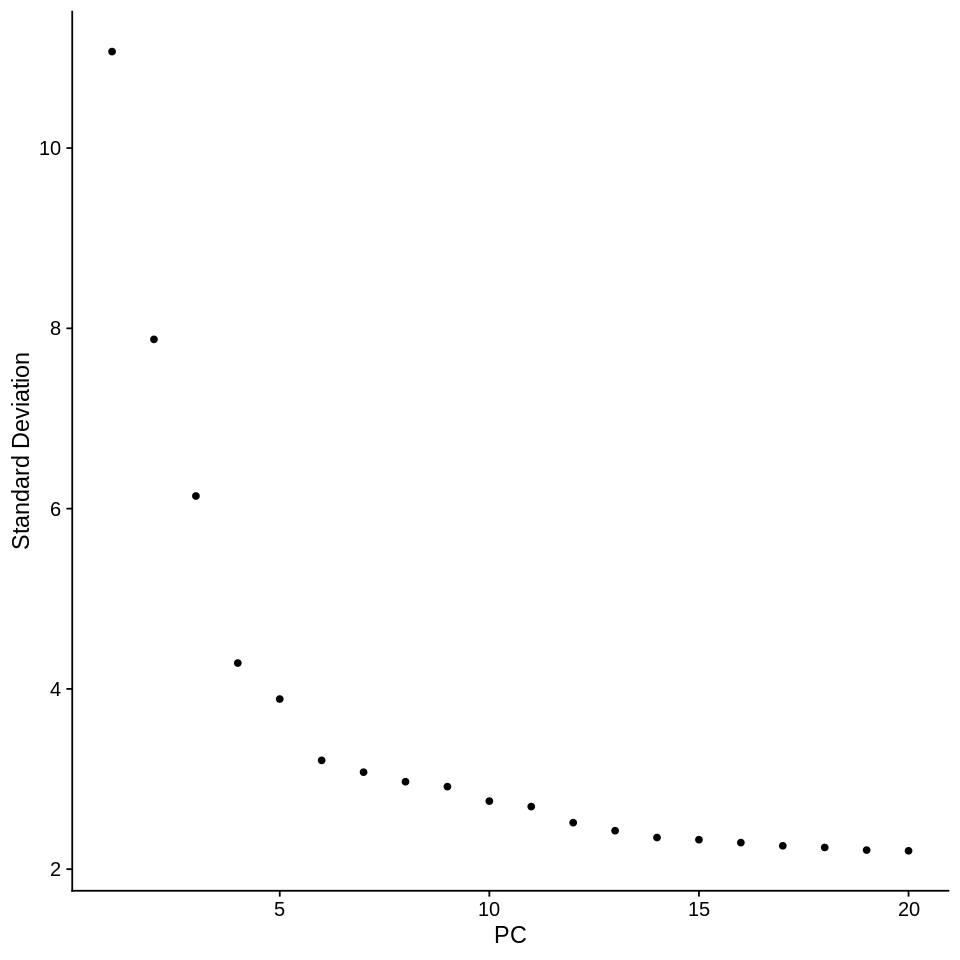

In [35]:
ElbowPlot(normal2)

In [36]:
normal2 <- FindNeighbors(normal2, dims = 1:15)
normal2 <- FindClusters(normal2, resolution = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2198
Number of edges: 78405

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8074
Number of communities: 11
Elapsed time: 0 seconds


In [37]:
normal2 <- RunUMAP(normal2, dims = 1:15)

13:55:02 UMAP embedding parameters a = 0.9922 b = 1.112

13:55:02 Read 2198 rows and found 15 numeric columns

13:55:02 Using Annoy for neighbor search, n_neighbors = 30

13:55:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:55:02 Writing NN index file to temp file /tmp/RtmpNRTwom/file82b7f63d01f52

13:55:02 Searching Annoy index using 1 thread, search_k = 3000

13:55:03 Annoy recall = 100%

13:55:03 Commencing smooth kNN distance calibration using 1 thread

13:55:03 Initializing from normalized Laplacian + noise

13:55:03 Commencing optimization for 500 epochs, with 89936 positive edges

13:55:05 Optimization finished



In [38]:
options(repr.plot.height=8,repr.plot.width=8)

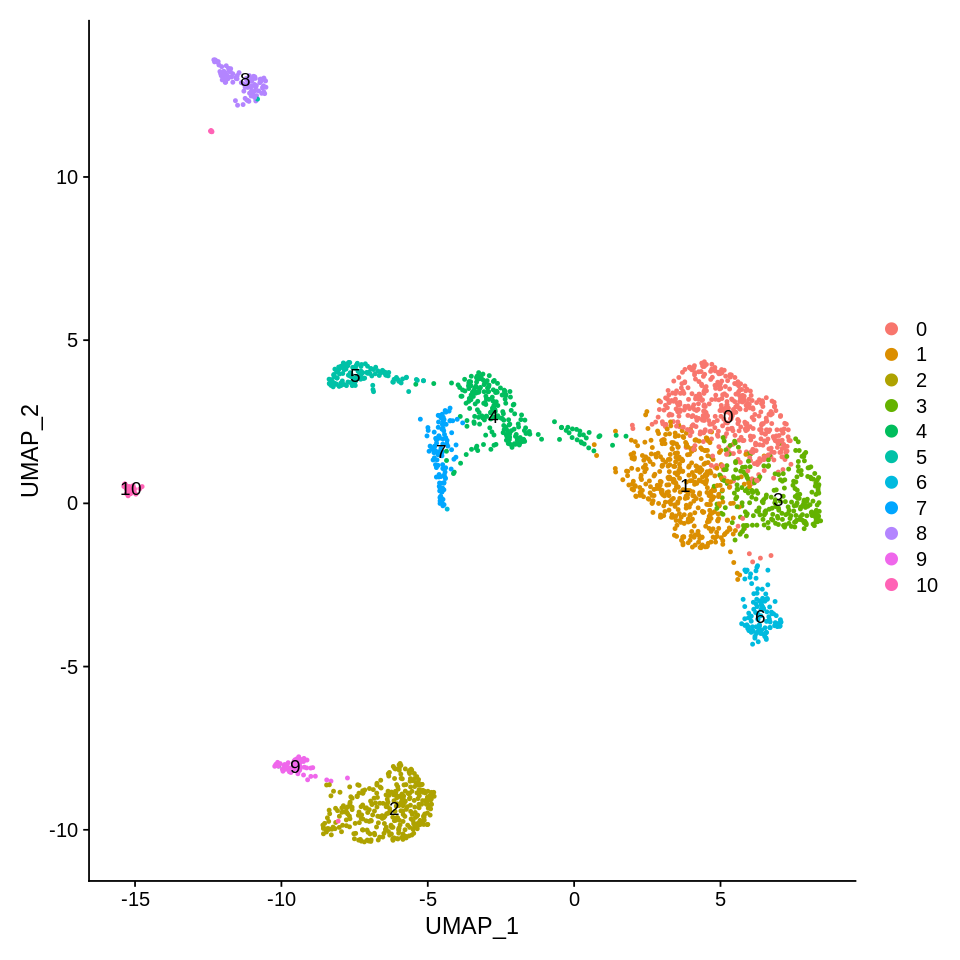

In [39]:
DimPlot(normal2, reduction = "umap",label=T)

In [40]:
options(repr.plot.height=9,repr.plot.width=7)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



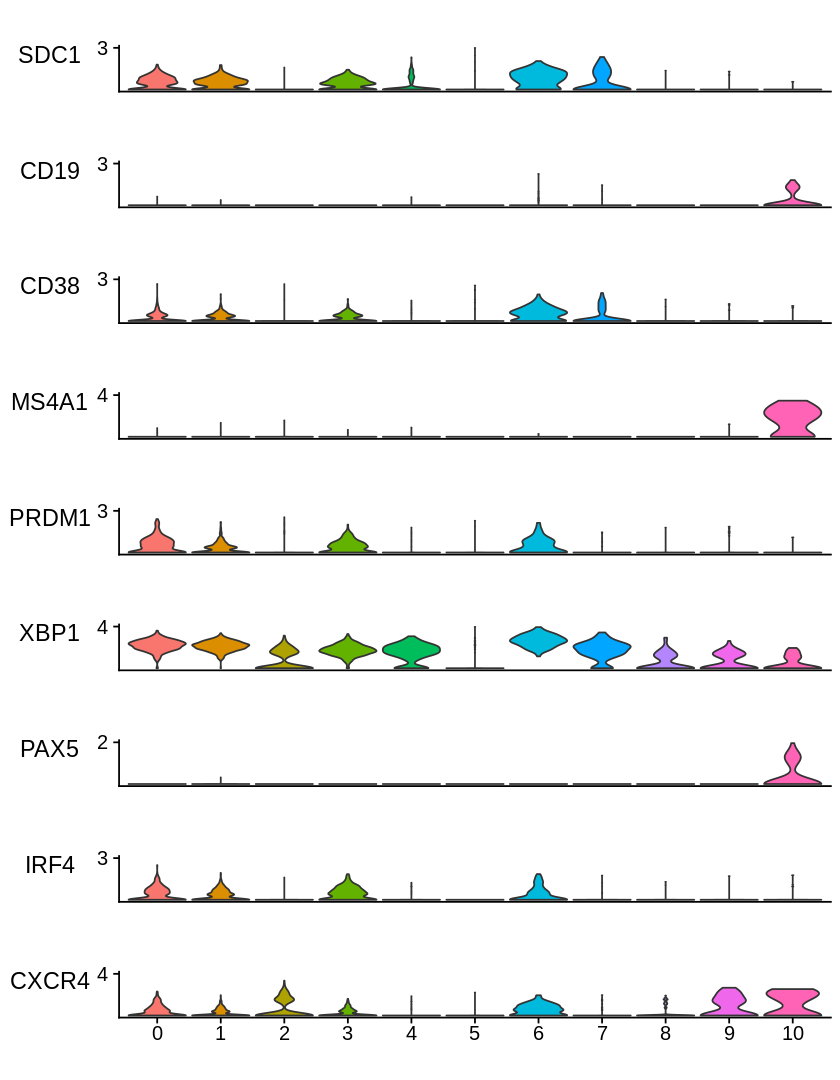

In [41]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



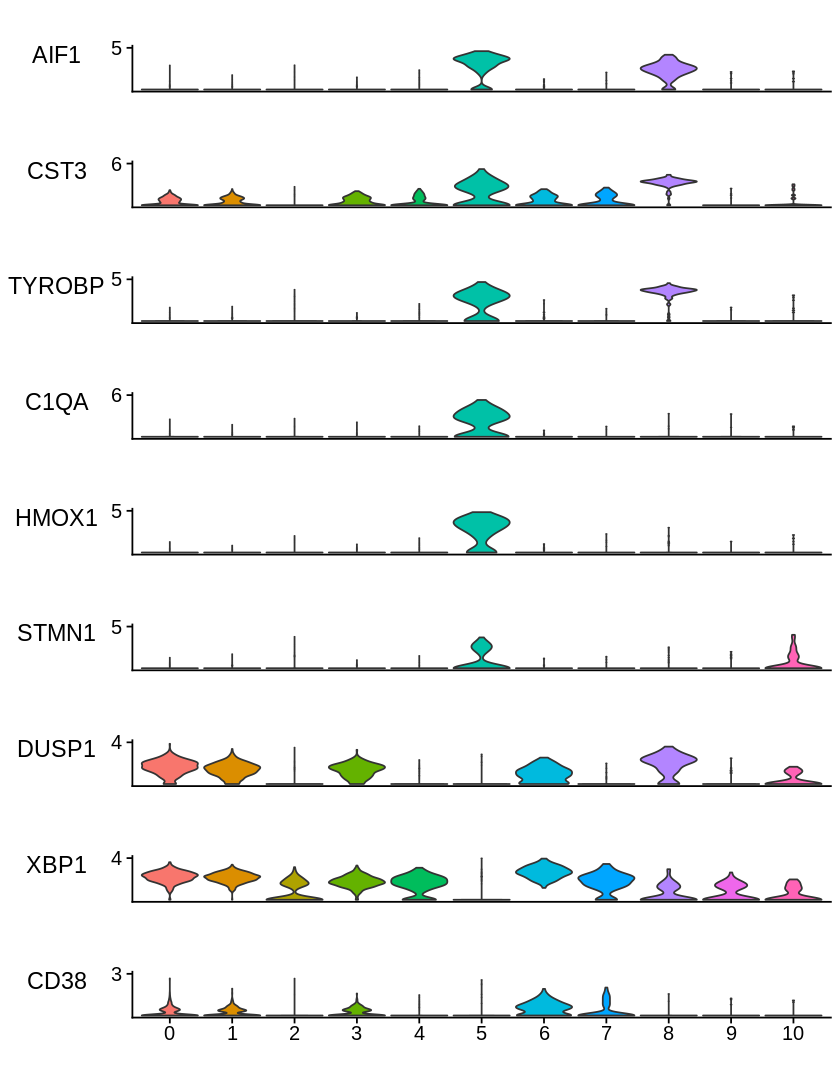

In [42]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =normal2, features = features)

In [43]:
options(repr.plot.height=6,repr.plot.width=6)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



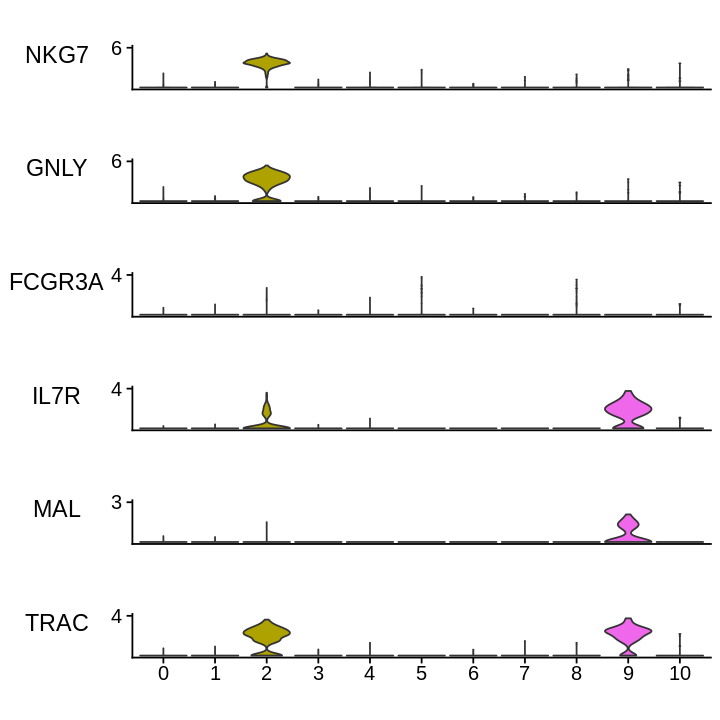

In [44]:
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



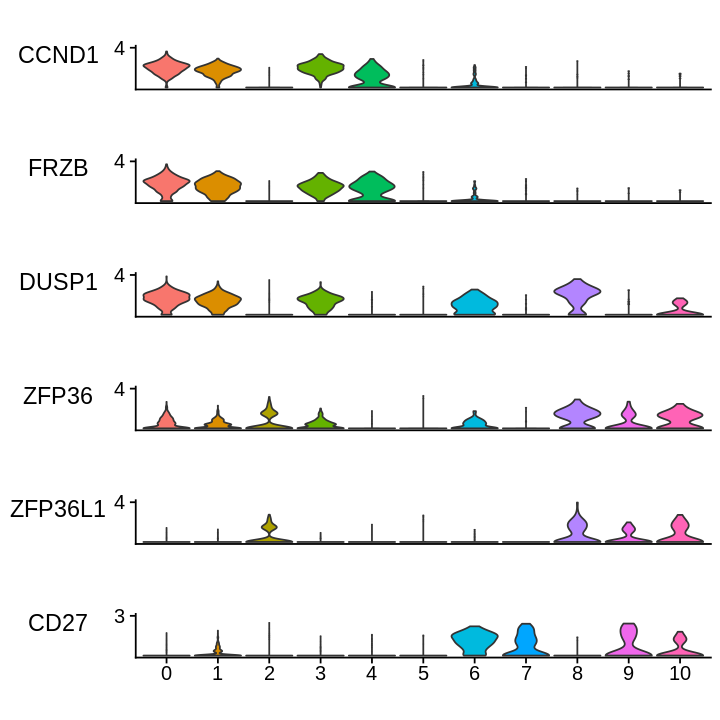

In [45]:
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =normal2, features = features)

In [46]:
options(repr.plot.height=4,repr.plot.width=8)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




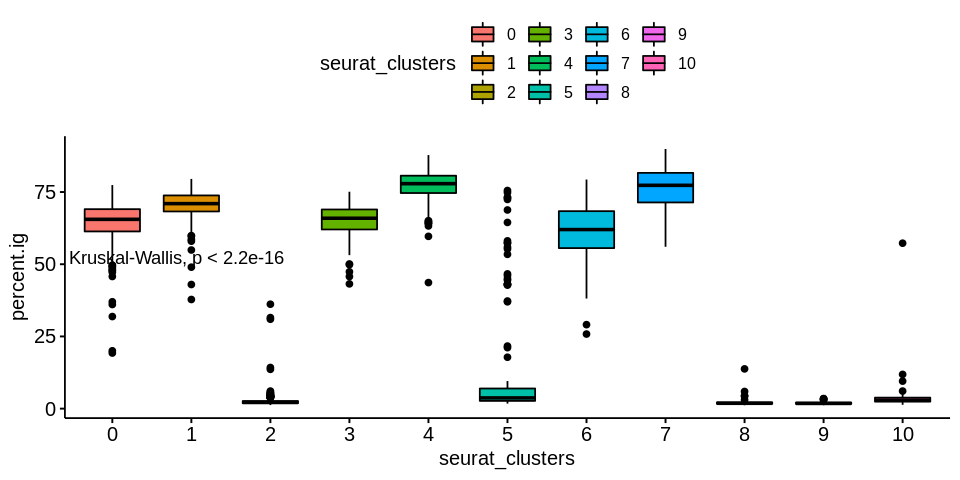

In [47]:
library(ggpubr)
library(RColorBrewer)
ggboxplot(normal2@meta.data, x="seurat_clusters", y="percent.ig", fill = "seurat_clusters")+
  stat_compare_means(label.y = 50)

In [48]:
normal3.markers <- FindAllMarkers(normal2, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
normal3.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
6.092154e-96,1.0477559,0.900,0.418,9.622557e-92,0,FOSB
2.550343e-95,1.1602047,0.989,0.514,4.028267e-91,0,CCND1
1.318324e-93,1.2589643,0.957,0.495,2.082293e-89,0,JUN
1.724453e-79,1.1407024,0.934,0.502,2.723774e-75,0,FRZB
2.519843e-67,0.9054791,0.947,0.533,3.980092e-63,0,DUSP1
1.460293e-79,0.9729064,1.000,0.973,2.306533e-75,1,IGHG1
8.739481e-77,0.8508033,1.000,0.967,1.380401e-72,1,IGHG4
1.620920e-73,0.9008615,1.000,0.999,2.560243e-69,1,IGHG3
7.755870e-52,0.7925928,1.000,1.000,1.225040e-47,1,IGLC2


In [49]:
options(repr.plot.height=10,repr.plot.width=10)

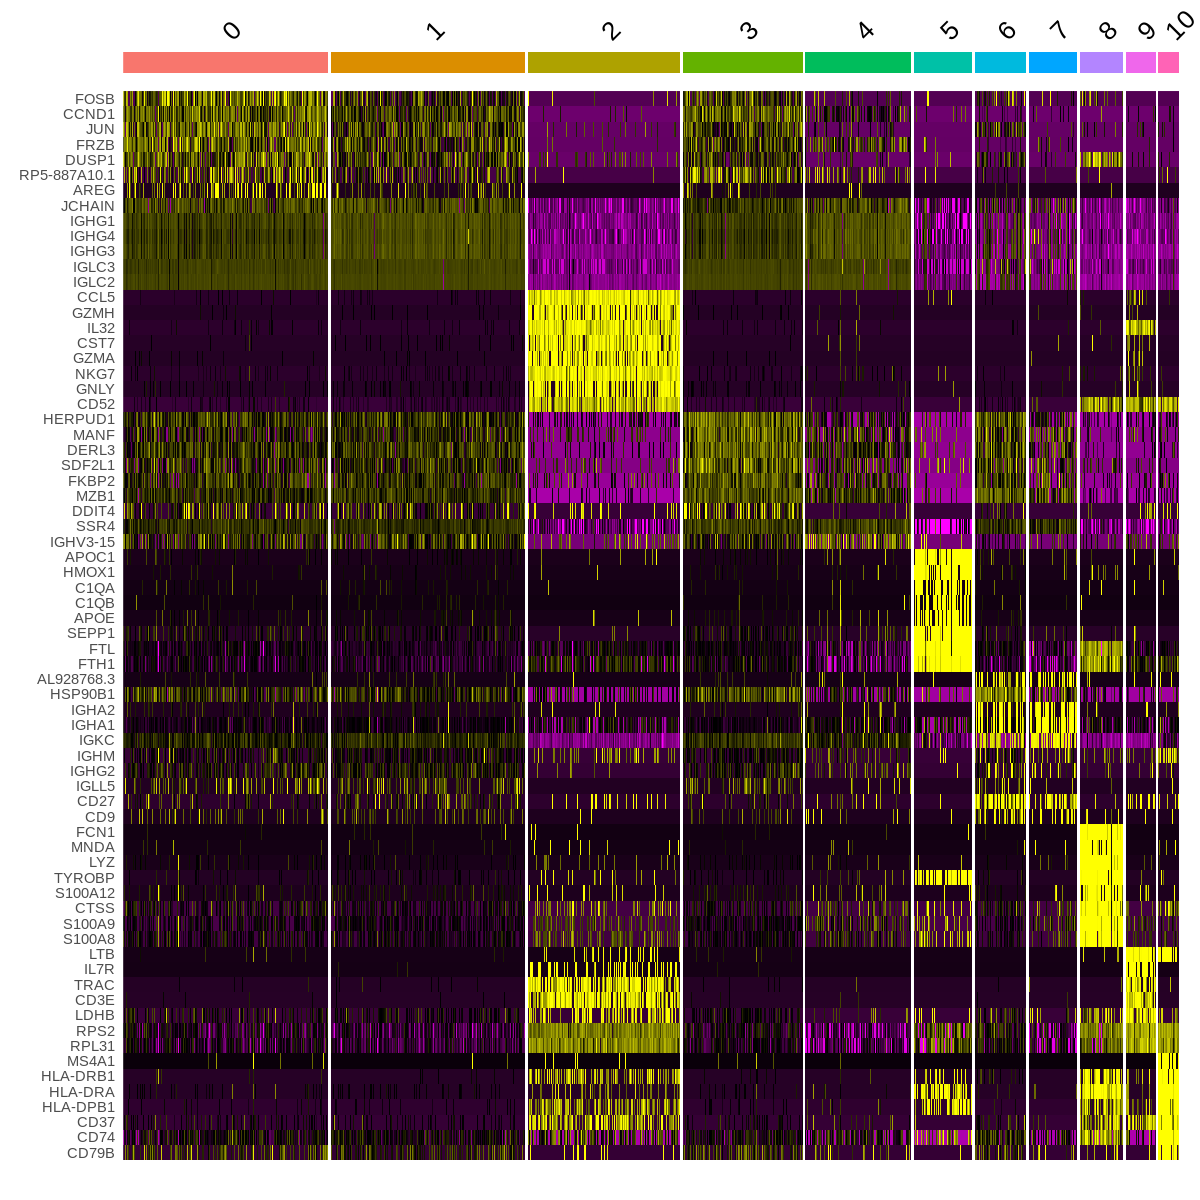

In [50]:
top10 <- normal3.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(normal2, features = top10$gene) + NoLegend()

In [51]:
library("Seurat")
library("SingleR")

In [52]:
counts<-normal2@assays$RNA@counts
clusters<-normal2@meta.data$seurat_clusters
ann=normal2@meta.data$orig.ident

In [53]:
singler = CreateSinglerObject(counts, annot = ann, "normal",
  species = "Human", citation = "",
  ref.list = list(), variable.genes = "de",
  fine.tune = F, do.signatures = T, clusters = clusters, do.main.types = T,
  reduce.file.size = T, numCores = 1)

[1] "Dimensions of counts data: 15795x2198"
[1] "Annotating data with HPCA..."
[1] "Variable genes method: de"
[1] "Number of DE genes:3235"
[1] "Number of cells: 2198"
[1] "Number of DE genes:3235"
[1] "Number of clusters: 11"
[1] "Annotating data with HPCA (Main types)..."
[1] "Number of DE genes:2530"
[1] "Number of cells: 2198"
[1] "Number of DE genes:2530"
[1] "Number of clusters: 11"
[1] "Annotating data with Blueprint_Encode..."
[1] "Variable genes method: de"
[1] "Number of DE genes:3088"
[1] "Number of cells: 2198"
[1] "Number of DE genes:3088"
[1] "Number of clusters: 11"
[1] "Annotating data with Blueprint_Encode (Main types)..."
[1] "Number of DE genes:2548"
[1] "Number of cells: 2198"
[1] "Number of DE genes:2548"
[1] "Number of clusters: 11"


In [54]:
singler$seurat = normal
singler$meta.data$xy = normal2@reductions$umap@cell.embeddings
clusterAnn=singler$singler[[2]]$SingleR.clusters.main$labels
clusterAnn

0,B-cells
1,B-cells
2,CD8+ T-cells
3,B-cells
4,B-cells
5,Macrophages
6,B-cells
7,B-cells
8,Monocytes
9,CD4+ T-cells
10,B-cells


In [55]:
clusterAnn<-as.data.frame(clusterAnn)
clusterAnn

,V1
,<chr>
0,B-cells
1,B-cells
2,CD8+ T-cells
3,B-cells
4,B-cells
5,Macrophages
6,B-cells
7,B-cells
8,Monocytes


In [56]:
type<-as.data.frame(singler$other)
type

,singler$other
,<chr>
AAACCTGAGATGCGAC-1,CD14+ Monocytes
AAACCTGAGGGTATCG-1,CD4 T cells
AAACCTGAGTCTTGCA-1,CD14+ Monocytes
AAACGGGAGGTGCACA-1,B cells
AAACGGGCAAGACACG-1,CD8 T cells
AAACGGGGTAAGGATT-1,FCGR3A+ Monocytes
AAACGGGGTGCAGTAG-1,CD14+ Monocytes
AAACGGGTCAATACCG-1,CD14+ Monocytes
AAACGGGTCCAGATCA-1,Megakaryocytes


In [57]:
count<-table(type)
count

type
          B cells   CD14+ Monocytes       CD4 T cells       CD8 T cells 
              362               732               410               299 
  Dendritic cells FCGR3A+ Monocytes    Megakaryocytes          NK cells 
              131               133                63                68 

In [58]:
names<-as.vector(rownames(normal2@meta.data))
type2<-type[names,]

In [59]:
plasma<-subset(normal2,ident=c(0,1,3,4,6,7))

In [60]:
options(repr.plot.height=8,repr.plot.width=8)

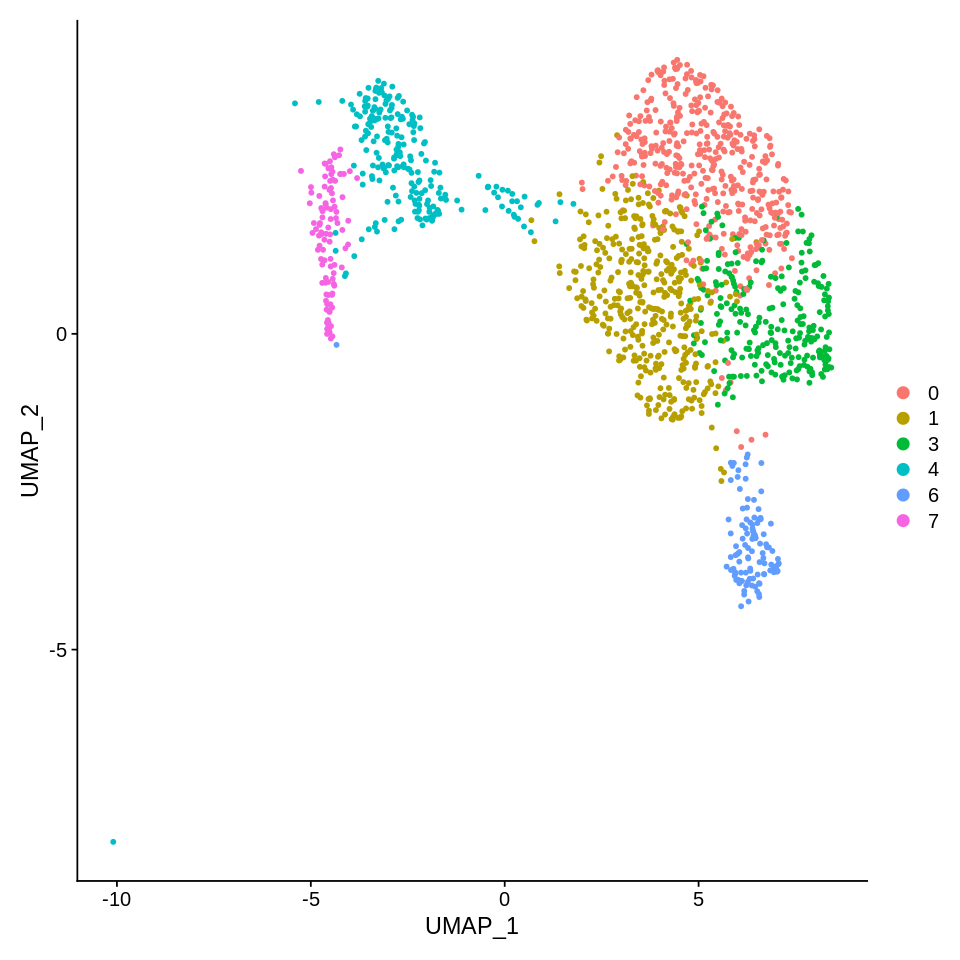

In [61]:
DimPlot(plasma, reduction = "umap")

In [62]:
plasma.markers <- FindAllMarkers(plasma, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
plasma.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 3

Calculating cluster 4

Calculating cluster 6

Calculating cluster 7



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
3.482367e-49,0.8028771,0.900,0.624,5.500399e-45,0,FOSB
6.232290e-44,0.8428642,0.957,0.710,9.843902e-40,0,JUN
1.823085e-41,0.7866302,0.947,0.699,2.879563e-37,0,DUSP1
4.084003e-40,0.7126519,1.000,0.944,6.450683e-36,0,MALAT1
8.166502e-40,0.7006126,0.989,0.767,1.289899e-35,0,CCND1
1.257519e-37,0.6839281,0.947,0.747,1.986251e-33,0,TSC22D3
2.464103e-30,0.7150324,0.934,0.763,3.892051e-26,0,FRZB
2.476952e-25,0.7035279,0.735,0.512,3.912346e-21,0,JUNB
2.222197e-23,0.6999582,0.370,0.159,3.509960e-19,0,AREG


In [63]:
options(repr.plot.height=8,repr.plot.width=8)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



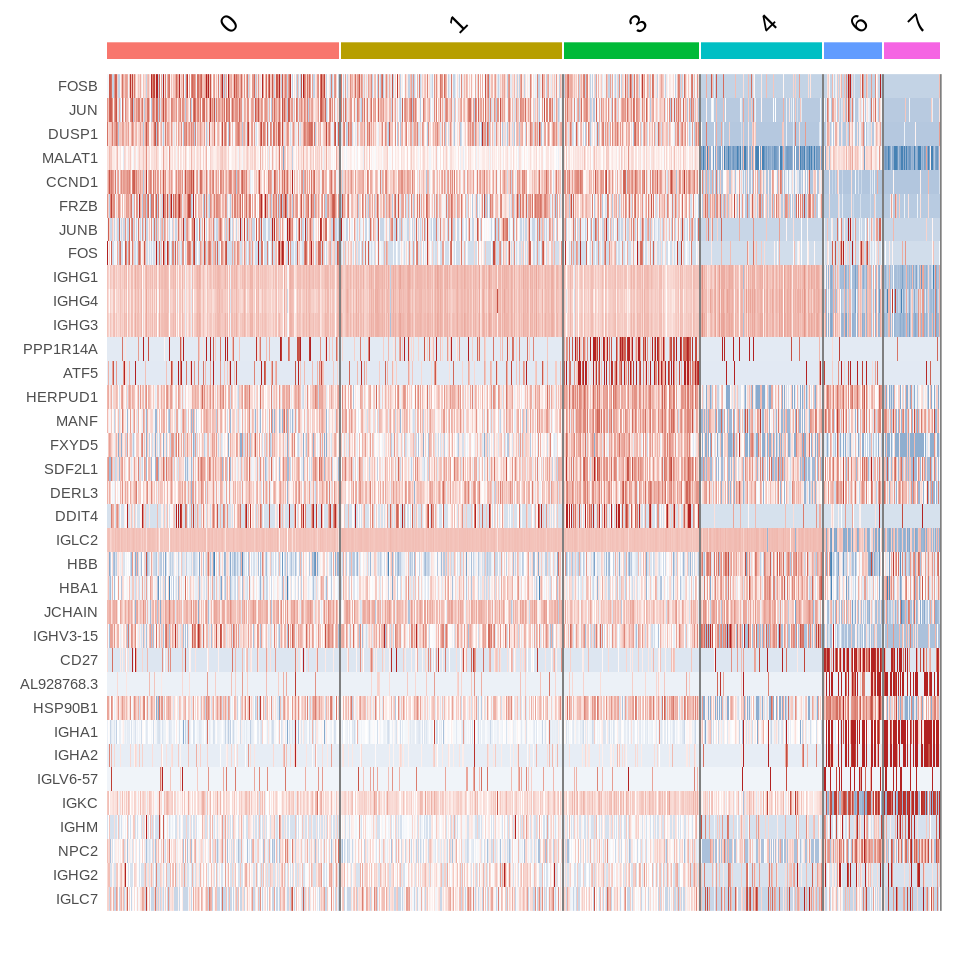

In [64]:
top10 <- plasma.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(plasma, features = top10$gene) + NoLegend()+ scale_fill_gradientn(colors = c("steelblue", "white", "firebrick"))

In [65]:
save(plasma,file="0709-MGUSPC1-plasma.Rda")

In [66]:
plasma

An object of class Seurat 
15795 features across 1550 samples within 1 assay 
Active assay: RNA (15795 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

In [67]:
options(repr.plot.height=9,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



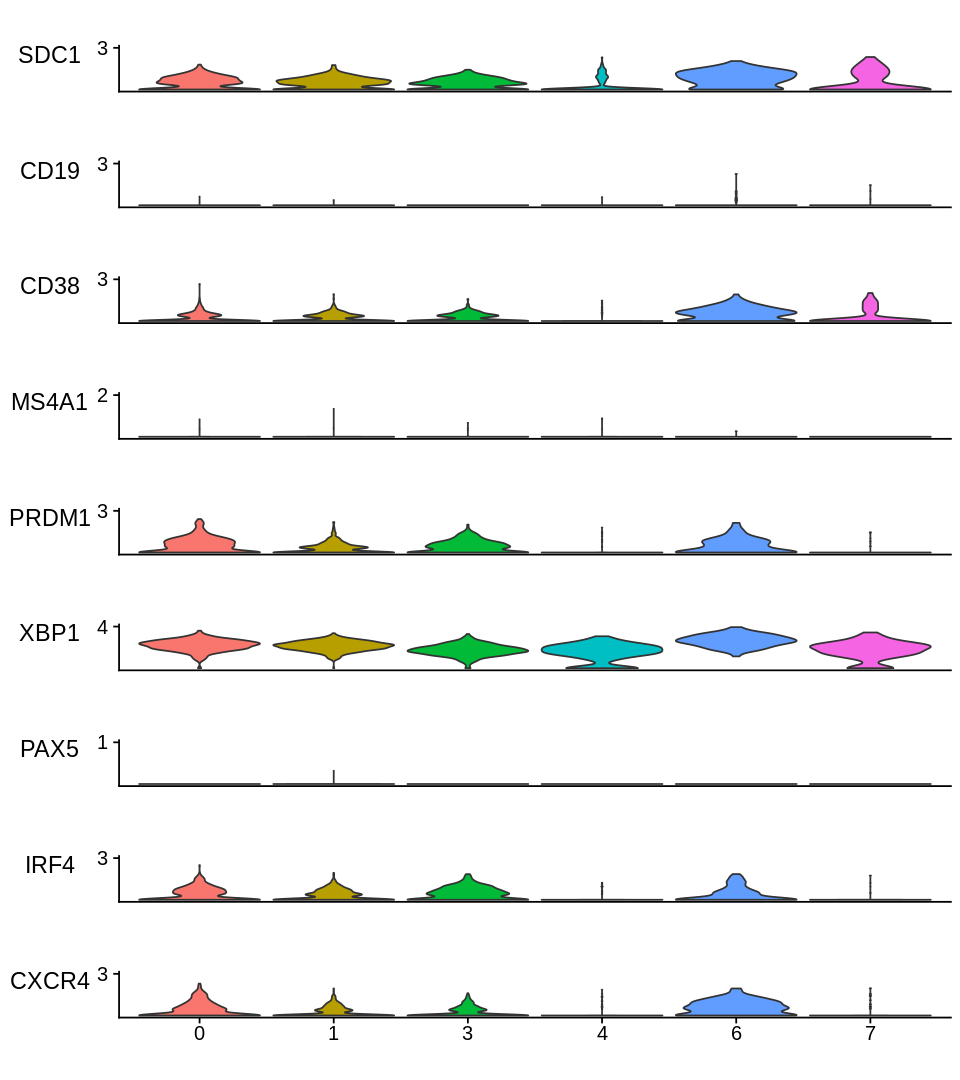

In [68]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



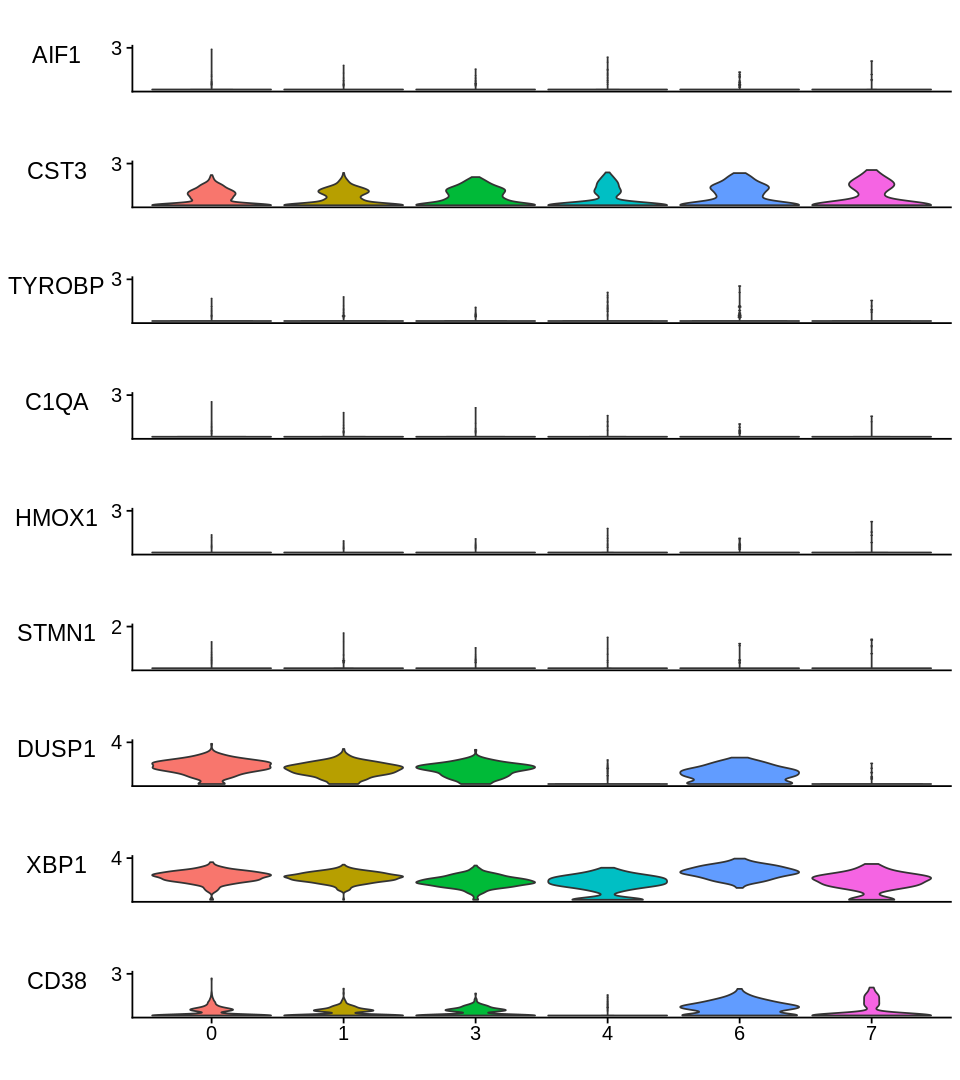

In [69]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =plasma, features = features)

In [70]:
options(repr.plot.height=6,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



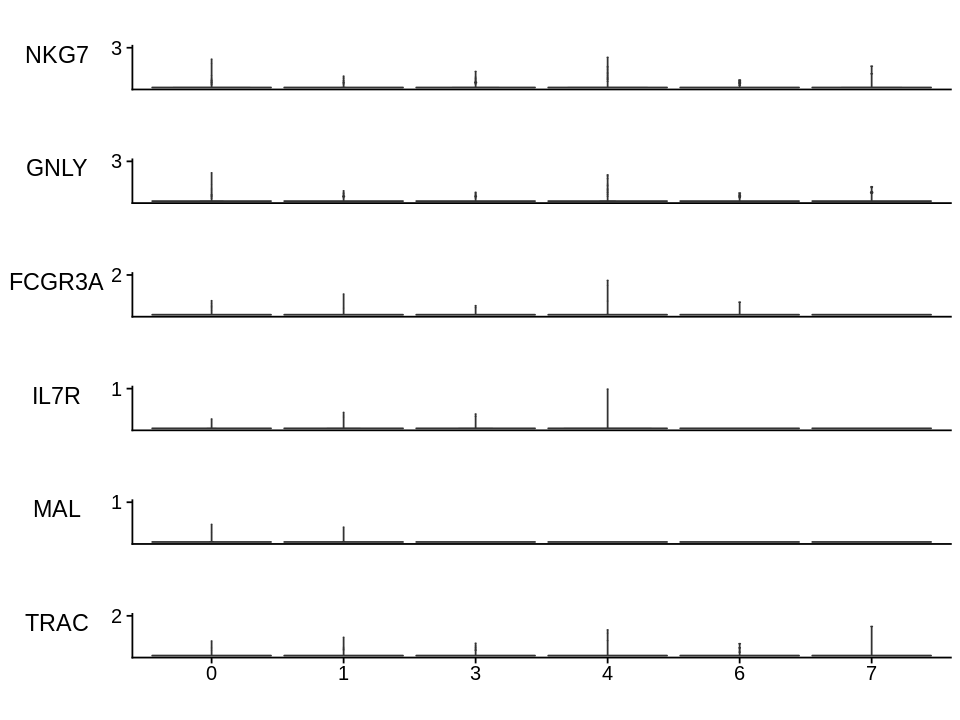

In [71]:
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



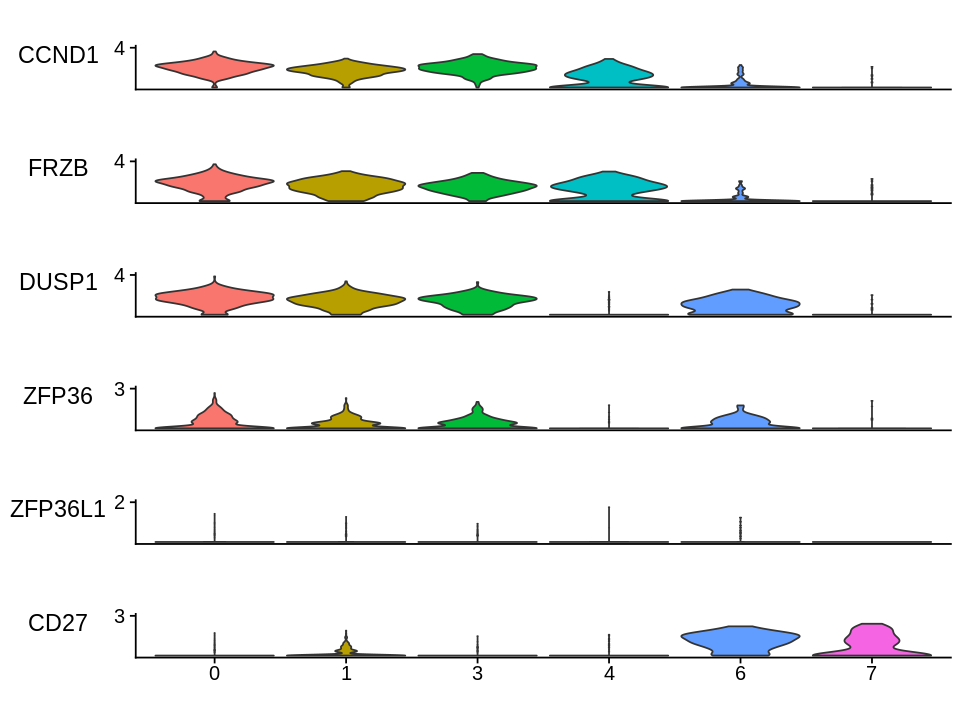

In [72]:
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =plasma, features = features)